In [32]:
import keras
from keras import layers
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np

In [33]:
# This is our input image
encoder_inputs = keras.Input(shape=(31), name="input_layer")
# "encoded" is the encoded representation of the input
x = layers.Dense(512, activation="relu")(encoder_inputs)
x = layers.Dense(256, activation="relu")(x)
x = layers.Dense(128, activation="relu")(x)

x = layers.Dense(128, activation="relu")(x)
x = layers.Dense(256, activation="relu")(x)
x = layers.Dense(512, activation="relu")(x)

cont_decoder_outputs = layers.Dense(30, activation="relu", name="cont_decoder_output")(x)
class_decoder_output = layers.Dense(1, activation="sigmoid", name="classification_output")(x)


autoencoder = keras.Model(encoder_inputs, [cont_decoder_outputs, class_decoder_output])

autoencoder.compile(
    optimizer="adam",
    loss={"cont_decoder_output": "mse", "classification_output": "binary_crossentropy"},
)

# Print the model summary
autoencoder.summary()

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_layer (InputLayer)       [(None, 31)]         0           []                               
                                                                                                  
 dense_30 (Dense)               (None, 512)          16384       ['input_layer[0][0]']            
                                                                                                  
 dense_31 (Dense)               (None, 256)          131328      ['dense_30[0][0]']               
                                                                                                  
 dense_32 (Dense)               (None, 128)          32896       ['dense_31[0][0]']               
                                                                                            

In [34]:
df_credit = pd.read_csv("../data/interim/creditcard_min_max.csv")
credit_array = df_credit.values
total_length = len(credit_array)  # Get the total number of elements in credit_array


twenty_percent_length = int(0.2 * total_length)  # Calculate 20% of the total length
# Slice the first 20 percent of the values in credit_array
credit_array_cut = credit_array[:twenty_percent_length]

# Specify the test_size and validation_size according to your needs
test_size = 0.2  # 80% training, 20% test
validation_size = 0.1  # 80% training, 10% validation

# Split into training and temporary data
train_data, temp_data = train_test_split(
    credit_array_cut, test_size=test_size + validation_size, random_state=42
)

# Split the temporary data into test and validation
test_data, validation_data = train_test_split(
    temp_data,
    test_size=validation_size / (test_size + validation_size),
    random_state=42,
)

In [35]:
from keras.callbacks import EarlyStopping

# Define the EarlyStopping callback
early_stopping_callback = EarlyStopping(
    monitor="val_loss",  # Monitoring validation loss
    patience=5,  # Number of epochs with no improvement after which training will be stopped
    restore_best_weights=True,  # Restore weights to the best model observed during training
)

# Fit the autoencoder model with two different outputs and their respective target data
autoencoder.fit(
    train_data,
    {
        "cont_decoder_output": train_data[:, :30],
        "classification_output": train_data[:, 30:],
    },  # Provide target data for each output
    epochs=20,
    batch_size=32,
    validation_data=(
        test_data,
        {
            "cont_decoder_output": test_data[:, :30],
            "classification_output": test_data[:, 30:],
        },
    ),  # Provide validation data here
    callbacks=[early_stopping_callback],
)

Epoch 1/20
1246/1246 [==============================] - 34s 3ms/step - loss: 0.0647 - cont_decoder_output_loss: 0.0615 - classification_output_loss: 0.0031 - val_loss: 0.0559 - val_cont_decoder_output_loss: 0.0559 - val_classification_output_loss: 1.0283e-05
Epoch 2/20
1246/1246 [==============================] - 4s 4ms/step - loss: 0.0538 - cont_decoder_output_loss: 0.0537 - classification_output_loss: 1.0586e-05 - val_loss: 0.0533 - val_cont_decoder_output_loss: 0.0533 - val_classification_output_loss: 8.2341e-06
Epoch 3/20
1246/1246 [==============================] - 4s 3ms/step - loss: 0.0532 - cont_decoder_output_loss: 0.0532 - classification_output_loss: 7.1463e-06 - val_loss: 0.0532 - val_cont_decoder_output_loss: 0.0532 - val_classification_output_loss: 4.9321e-06
Epoch 4/20
1246/1246 [==============================] - 4s 4ms/step - loss: 0.0420 - cont_decoder_output_loss: 0.0420 - classification_output_loss: 3.3606e-05 - val_loss: 0.0310 - val_cont_decoder_output_loss: 0.0310 

In [36]:
generated_data = autoencoder.predict(test_data)

356/356 [==============================] - 1s 2ms/step


In [37]:
reconstructed_cont_output = generated_data[0]
reconstructed_class_output = generated_data[1]

In [48]:
binary_predictions = (reconstructed_class_output >= 0.5).astype(int)

In [56]:
sum(test_data[:, 30])/len(test_data)

0.0028967696629213485

In [55]:
sum(binary_predictions)/len(binary_predictions)

array([0.00289677])

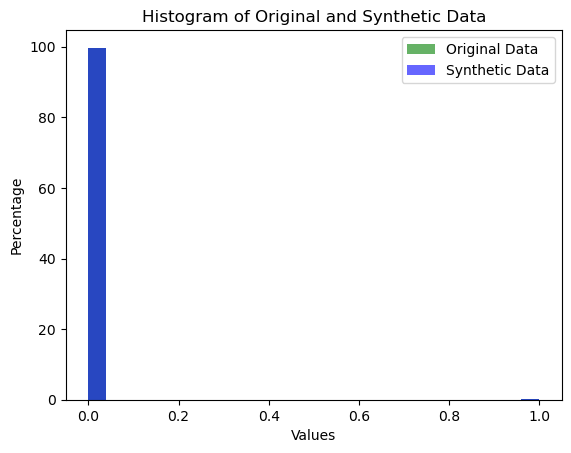

In [54]:
# Assuming iris_array is the NumPy array you obtained from the Pandas DataFrame
colum_num = 14
original_column = train_data[:, 30]

synth_column = binary_predictions

# Calculate the percentage for original_column
total_points_original = len(original_column)
percentage_original = (original_column / total_points_original) * 100

# Calculate the percentage for synth_column
total_points_synth = len(synth_column)
percentage_synth = (synth_column / total_points_synth) * 100

# Plot histograms
plt.hist(
    original_column,
    bins=25,
    color="g",
    alpha=0.6,
    weights=np.ones_like(original_column) / total_points_original * 100,
    label="Original Data",
)

plt.hist(
    synth_column,
    bins=25,
    color="b",
    alpha=0.6,
    weights=np.ones_like(synth_column) / total_points_synth * 100,
    label="Synthetic Data",
)

plt.title("Histogram of Original and Synthetic Data")
plt.xlabel("Values")
plt.ylabel("Percentage")
plt.legend()
plt.show()